In [1]:
import os
from PIL import Image, ImageFont
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.ndimage import filters
import cv2
from captum.attr import visualization

import clip
from clip.simple_tokenizer import SimpleTokenizer
from utils.initialize_font_data import (
    font_dir,
    fox_text,
    fox_text_four_lines,
    train_json_path,
    exclusive_attributes,
    gray_scale_image_file_dir,
)
from utils.init_model import (
    device,
    model_name,
    load,
    load_model,
)
from utils.transform_image import draw_text_with_new_lines
from utils.dataset import MyDataset, set_image_tensors
from utils.coop_model import CoOpCLIP

tokenizer = SimpleTokenizer()

exclusive_attributes:  []
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
model, preprocess = load(model_name, device=device, jit=False, use_attention_hook=True)
fclip_model, preprocess = load(model_name, device=device, jit=False, use_attention_hook=True)

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [21]:
def interpret(
    image,
    texts,
    model,
    device,
    start_layer=-1,
    start_layer_text=-1,
):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros(
        (logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32
    )
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(
        dict(model.visual.transformer.resblocks.named_children()).values()
    )

    if start_layer == -1:
        # calculate index of last layer
        start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    # num_tokens = image_attn_blocks[0].attn_mask.shape[-1]
    R = torch.eye(
        num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype
    ).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[
            0
        ].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
        # calculate index of last layer
        start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(
        num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype
    ).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[
            0
        ].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis("off")

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(
        image_relevance, size=224, mode="bilinear"
    )
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (
        image_relevance.max() - image_relevance.min()
    )
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].axis("off")

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    print(text_scores)
    text_tokens = tokenizer.encode(text)
    text_tokens_decoded = [tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [
        visualization.VisualizationDataRecord(
            text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1
        )
    ]
    visualization.visualize_text(vis_data_records)

def show_attention_map(model, img_text, texts, font_path, character_size=200):
  line_count = img_text.count("\n") + 1
  img_width = len(max(img_text.split("\n"), key=len)) * character_size
  img_height = character_size * (line_count)
  font = ImageFont.truetype(font_path, character_size)
  image = draw_text_with_new_lines(
      img_text, font, img_width=img_width, img_height=img_height,
  )
  preprocessed_image = preprocess(image)
  for _, param in model.named_parameters():
      param.requires_grad = True

  img = preprocessed_image.unsqueeze(0).to(device)
  text = clip.tokenize(texts).to(device)

  R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
  batch_size = text.shape[0]
  for i in range(batch_size):
      show_heatmap_on_text(texts[i], text[i], R_text[i])
      show_image_relevance(R_image[i], img, orig_image=image)
      plt.show()

In [22]:
checkpoint_path = "model_checkpoints/cv_5_0_ViT-B_32_bce_loss_9101191011_batch64_aug250_lower_bound_of_scale0.35_max_attribute_num_3_random_prompts_num_70000_use_negative_lr2e-05-0.1_image_file_dir.pt"
checkpoint_path = "model_checkpoints/cv_5_1_ViT-B_32_bce_9101191011_batch64_aug10_lower_bound_of_scale0.35_max_attribute_num_3_random_prompts_num_70000_single_character_use_negative_lr2e-05-0.1.pt"
fclip_model = load_model(fclip_model, checkpoint_path=checkpoint_path, use_attention_hook=True)

tensor([0.1915, 0.5254, 0.2837], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,ser if font


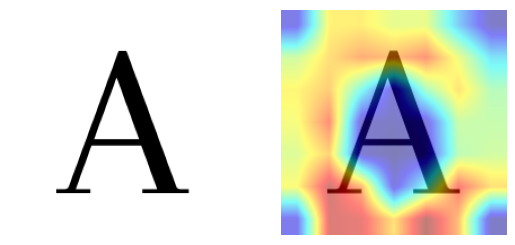

tensor([0.3225, 0.2201, 0.2469, 0.2102], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,not ser if font


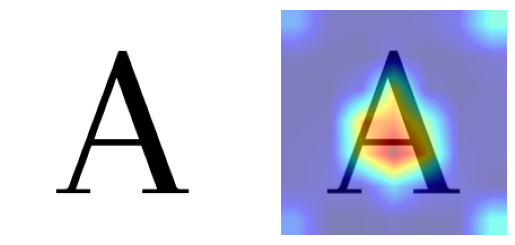

tensor([0.3755, 0.3882, 0.2363], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,itali c font


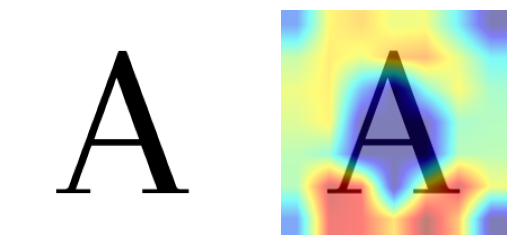

In [25]:
img_text = 'A'
texts = [
  'serif font',
  'not serif font',
  'italic font',
]
font_path = '../gwfonts/Arapey-Regular.ttf'
show_attention_map(fclip_model, img_text=img_text, texts=texts, font_path=font_path)

tensor([0.2974, 0.4922, 0.2102], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,ser if font


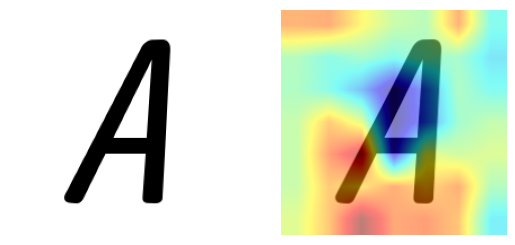

tensor([0.2651, 0.2532, 0.2365, 0.2449], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,not ser if font


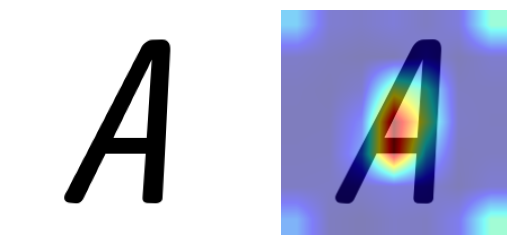

tensor([0.2876, 0.4641, 0.2479], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,itali c font


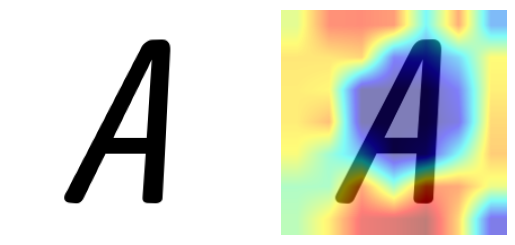

In [26]:
font_path = "../gwfonts/Allan-Regular.ttf"
show_attention_map(fclip_model, img_text=img_text, texts=texts, font_path=font_path)